In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Flatten, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
import json
data = [json.loads(line) for 
        line in open('Sarcasm_Dataset.json', 'r')]

In [4]:
new_df = pd.DataFrame.from_dict(data) 

In [5]:
new_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
new_df2 = new_df.drop(['article_link'],axis=1)

In [7]:
new_df2.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
new_df2["headline_len"] = new_df2["headline"].str.len()

In [9]:
new_df2.head()

,headline,is_sarcastic,headline_len
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


In [10]:
max_features = 10000
maxlen = 25
embedding_size = 200

In [11]:
# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(new_df2['headline'])

In [12]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [13]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(new_df2['headline'])

In [14]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
X = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=maxlen)

In [15]:
Y = new_df2["is_sarcastic"].values

In [16]:
print(type(Y))

<class 'numpy.ndarray'>


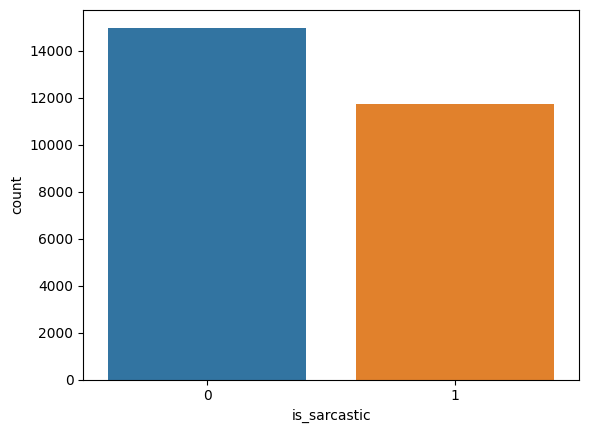

In [17]:
sns.countplot(x='is_sarcastic',data=new_df2);

In [18]:
tokenizer.word_index

{'<unk>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'this': 19,
 'by': 20,
 'after': 21,
 'up': 22,
 'out': 23,
 'be': 24,
 'how': 25,
 'as': 26,
 'it': 27,
 'that': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'his': 32,
 'what': 33,
 'he': 34,
 'all': 35,
 'just': 36,
 'who': 37,
 'has': 38,
 'will': 39,
 'more': 40,
 'one': 41,
 'into': 42,
 'report': 43,
 'year': 44,
 'why': 45,
 'have': 46,
 'area': 47,
 'over': 48,
 'donald': 49,
 'u': 50,
 'day': 51,
 'says': 52,
 's': 53,
 'can': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'like': 58,
 'her': 59,
 "trump's": 60,
 'old': 61,
 'no': 62,
 'get': 63,
 'off': 64,
 'an': 65,
 'life': 66,
 'people': 67,
 'obama': 68,
 'now': 69,
 'house': 70,
 'still': 71,
 "'": 72,
 'women': 73,
 'make': 74,
 'was': 75,
 'than': 76,
 'white': 77,
 'back': 78,
 'my': 79,
 'i': 80,
 'clinton': 81,
 '

In [19]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

29660


In [21]:
EMBEDDING_FILE = 'glove.6B.200d.txt'

embeddings = {}
with open(EMBEDDING_FILE, 'r', encoding='utf-8') as f:
    for o in f:
        word = o.split(" ")[0]
        embd = o.split(" ")[1:]
        embd = np.asarray(embd, dtype='float32')
        embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [22]:
lstm_out = 196

# define the model
model1 = Sequential()
model1.add(Embedding(num_words,
                    embedding_size,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=False))
model1.add(SpatialDropout1D(0.4))
model1.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

In [23]:
# compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 200)           5932000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 200)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 392)              622496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 1)                 393       
                                                                 
Total params: 6,554,889
Trainable params: 622,889
Non-tr

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(21367, 25) (21367,)
(5342, 25) (5342,)


In [25]:
from keras.callbacks import ModelCheckpoint

# define the checkpoint filepath
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

# define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model with the checkpoint callback
history1 = model1.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[checkpoint])

Epoch 1/10
301/301 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7154
Epoch 1: val_accuracy improved from -inf to 0.76790, saving model to weights-improvement-01-0.77.hdf5
301/301 [==============================] - 63s 190ms/step - loss: 0.5518 - accuracy: 0.7154 - val_loss: 0.4664 - val_accuracy: 0.7679
Epoch 2/10
301/301 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.7838
Epoch 2: val_accuracy improved from 0.76790 to 0.83996, saving model to weights-improvement-02-0.84.hdf5
301/301 [==============================] - 55s 184ms/step - loss: 0.4542 - accuracy: 0.7838 - val_loss: 0.3607 - val_accuracy: 0.8400
Epoch 3/10
301/301 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8126
Epoch 3: val_accuracy did not improve from 0.83996
301/301 [==============================] - 56s 185ms/step - loss: 0.4001 - accuracy: 0.8126 - val_loss: 0.3351 - val_accuracy: 0.8400
Epoch 4/10
301/301 [==============================] 

In [26]:
# 假设要预测的句子为 "report: it still nowhere near okay to act like donald trump."
text = "report: it still nowhere near okay to act like donald trump."
# 将句子转换为数字序列
seq = tokenizer.texts_to_sequences([text])
# 对数字序列进行填充，使其长度与训练数据相同
seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=maxlen, padding='post')

# 使用训练好的模型进行预测
y_pred = model1.predict(seq)[0][0]
print(model1.predict(seq))
print(y_pred)
# 对输出结果进行解释和解读
if y_pred >= 0.5:
    print("The remark was probably sarcastic")
else:
    print("The remark was probably not sarcastic")

1/1 [==============================] - 0s 32ms/step
[[0.96729285]]
0.96729285
The remark was probably sarcastic


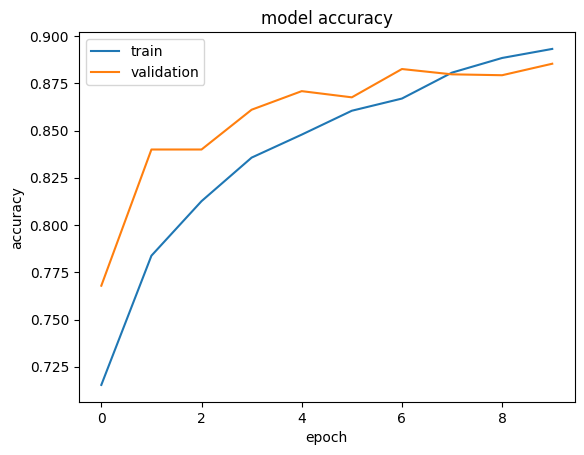

In [27]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

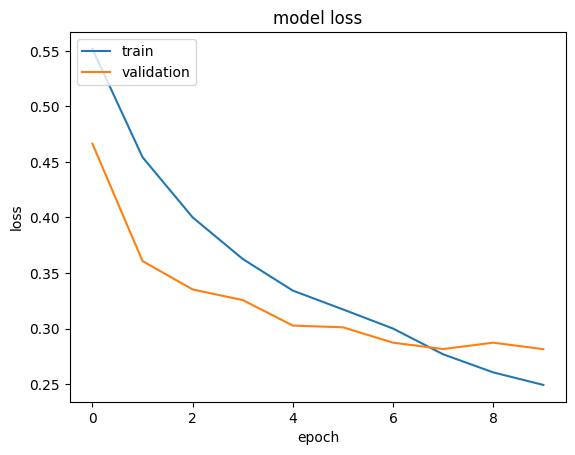

In [28]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

In [29]:
loss1, accuracy1 = model1.evaluate(X_test, Y_test)

167/167 [==============================] - 5s 32ms/step - loss: 0.2954 - accuracy: 0.8783


In [30]:
print(f'My test1 loss is {loss1*100:.2f}% and test1 accuracy is {accuracy1*100:.2f}%')

My test1 loss is 29.54% and test1 accuracy is 87.83%


In [31]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

167/167 [==============================] - 6s 33ms/step


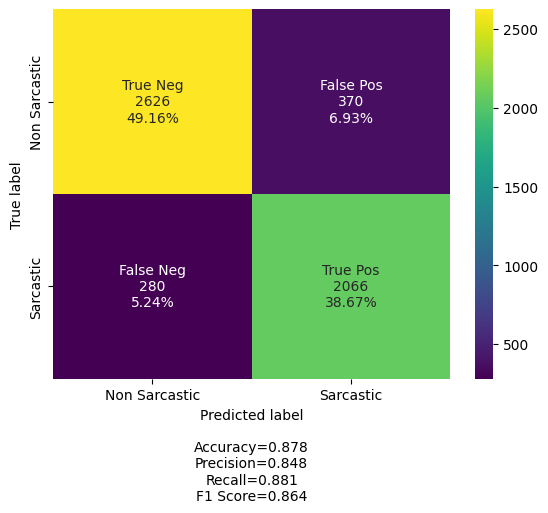

In [35]:
y_pred = np.round(model1.predict(X_test)).astype(int)
cf_matrix = confusion_matrix(Y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non Sarcastic','Sarcastic']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='viridis')

167/167 [==============================] - 5s 30ms/step


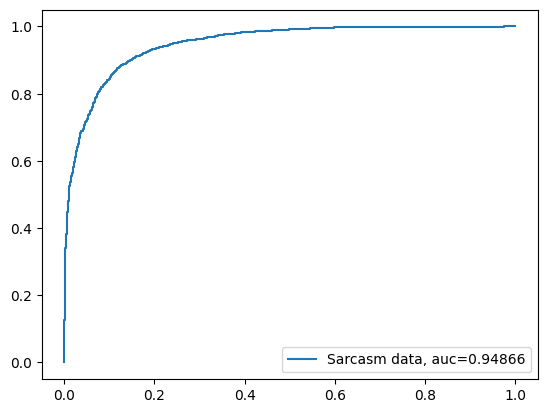

In [38]:
# 设置打印选项，将小数点后的位数设置为 5
np.set_printoptions(precision=5)

# 获取模型的预测结果
y_pred_proba = model1.predict(X_test)

# 计算 FPR、TPR 和阈值
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label="Sarcasm data, auc=%.5f" % auc)
plt.legend(loc=4)
plt.show()